In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
# Note - acceleration and deceleration will be equal
BUS_LENGTH = 18.3 # https://en.wikipedia.org/wiki/Classic_(transit_bus)
BUS_ACCELERATION = 2 # https://hypertextbook.com/facts/2001/MeredithBarricella.shtml
CAR_LENGTH = 4.7 # https://en.wikipedia.org/wiki/Mid-size_car
CAR_ACCELERATION = 4 # https://hypertextbook.com/facts/2001/MeredithBarricella.shtml

## Define the roadway


# LIGHT_LOCATIONS = [500, 1000]
# LIGHT_DUTIES = [1, 1]
# LIGHT_CYCLES = [60, 60]
# LIGHT_PHASES = [0, 0]


# LIGHT_LOCATIONS = [100, 500, 1200, 1400, 2000] # Vehicles enter at zero meters
# LIGHT_DUTIES = [0.7, 0.5, 0.5, 0.6, 0.8]
# LIGHT_CYCLES = [60, 40, 60, 40, 60]
# LIGHT_PHASES = [0, 15, 30, 45, 30]


LIGHT_LOCATIONS = [500, 1500, 3000]
LIGHT_DUTIES = [0.5, 0.5, 0.5]
LIGHT_CYCLES = [60, 90, 90]
LIGHT_PHASES = [0, 0, 0]


## Simulation parameters
TIMESTEP = 0.03
NUM_LANES = 1
SPEED_LIMIT = 30 # Defines the max speed for all vehicles
SPACING = 2 # meters between cars
STARTING_SPEED = SPEED_LIMIT/5
SIMULATION_DURATION = 7200 # two hours
TOTAL_CARS = 2400
TOTAL_BUSES = 30
SECONDS_TO_PRINT = SIMULATION_DURATION/10

BRT = False # default

assert(SPEED_LIMIT*TIMESTEP < SPACING*0.5) # should guarantee stopping in time

In [3]:
 # globals to store exited vehicle information
CAR_DURATIONS = []
CAR_STOP_DURATIONS = []
CAR_QUEUE_DURATIONS = []

BUS_DURATIONS = []
BUS_STOP_DURATIONS = []
BUS_QUEUE_DURATIONS = []

In [4]:
class Light(object):
    '''
    Represents a traffic signal
    
    var: loc, where it is on the street
    var: duty, percent of cycle the signal is green
    var: cycle, duration of cycle in seconds
    var: phase, offset from time zero of cycle start, in seconds
    
    var: bus_waiting, whether a bus needs to be prioritized
    var: bus_waiting_stamp, the time at which a bus needs to be prioritized
    '''
    def __init__(self, loc, duty, cycle, phase):
        self.loc = loc
        self.duty = duty
        self.cycle = cycle
        self.phase = phase
        
        self.bus_waiting = False
        self.bus_waiting_for = None
        return
    
    def green(self, time):
        '''
        Returns true if the light is green at a given time
        '''
        if ((time-self.phase) % self.cycle) < (self.duty*self.cycle) or self.bus_waiting:
            return True
        else:
            return False

In [5]:
class Vehicle(object):
    '''
    Represents a vehicle on the road
    
    var: max_speed, the fastest a vehicle will go (m/s)
    var: acceleration, the acceleration (m/s^2)
    var: length, the length of the vehicle
    
    var: speed, the current speed of the vehicle
    var: position, the current position of the front of the vehicle
    var: stopping_distance, the current stopping distance of the vehicle
    var: next_light, the light immediately in front of the vehicle
    
    var: lane, the lane the vehicle occupies, index not object
    
    var: duration, the time since the vehicle entered the roadway
    var: time_stopped, the time the vehicle spent stopped
    var: time_queued, the time the vehicle has spent waiting to 
                enter the roadway
    var: v_id, the id for the vehicle map in the lane
    '''
    def __init__(self, is_bus, max_speed, acceleration, length, \
                 lane_idx, start=0, speed=STARTING_SPEED, position=0):
        '''
        Fixed and starting values
        '''
        self.is_bus = is_bus
        self.max_speed = max_speed
        self.acceleration = acceleration
        self.length = length
        
        self.lane_idx = lane_idx
        
        self.speed = speed
        self.position = position
        self.update_stopping_distance()
        self.next_light = 0
        
        self.start = start
        
        self.duration = 0
        self.time_stopped = 0
        self.time_queued = 0
        self.v_id = -1
        
        return
    
    def reset(self):
        self.speed = STARTING_SPEED
        self.position = 0
        self.update_stopping_distance()
        
        self.duration = 0
        self.time_stopped = 0
        self.time_queued = 0
        
        self.v_id = -1
        
        return
        
    def step(self, road, time_step):
        '''
        param: lights, list of Light objects on the roadway
        param: road, Road object that holds lanes of the road
        param: time_step, duration of time to simulate
        '''
        my_lane = road.lanes[self.lane_idx]
        # vf^2 = vi^2 + 2*a*d, a is negative
        self.update_stopping_distance()
  
        ## TODO: incorporate BRT
        if self.is_bus and BRT:
#             obstructed = my_lane.obstructed(self.position, \
#                                             self.stopping_distance)
            obstructed = my_lane.obstructed(self)
#             road.signal_lights(self, self.position, self.stopping_distance)
            road.signal_lights(self)
            
#             stopped = road.stopped(self.position, self.stopping_distance)
            stopped = road.stopped(self)
            if not (obstructed or stopped):
                self.accelerate(time_step)
            else:
                self.decelerate(time_step)
        else:
#             obstructed = my_lane.obstructed(self.position, \
#                                             self.stopping_distance)
            obstructed = my_lane.obstructed(self)
#             stopped = road.stopped(self.position, self.stopping_distance)
            stopped = road.stopped(self)
            if not (obstructed or stopped):
                self.accelerate(time_step)
            else:
                self.decelerate(time_step)
            
        return
    
    def update_stopping_distance(self):
        self.stopping_distance = (self.speed**2)/(2*self.acceleration)
        return
    
    def accelerate(self, time_step):
        if self.speed < self.max_speed:
            self.speed += time_step*self.acceleration
            if self.speed > self.max_speed:
                self.speed = self.max_speed
        self.move(time_step)
        return
    
    def decelerate(self, time_step):
        self.reduce_speed(time_step)
        self.move(time_step)
        return
    
    def reduce_speed(self, time_step):
        if self.speed > 0:
            self.speed -= time_step*self.acceleration
            if self.speed < 0:
                self.speed = 0
        else:
            self.time_stopped += time_step
    
    def move(self, time_step):
        self.position += self.speed*time_step
        self.duration += time_step
        return
    
    def exit(self):
        if self.is_bus:
            BUS_DURATIONS.append(self.duration)
            BUS_STOP_DURATIONS.append(self.time_stopped + self.time_queued)
#             BUS_QUEUE_DURATIONS.append(self.time_queued)
        else:
            CAR_DURATIONS.append(self.duration)
            CAR_STOP_DURATIONS.append(self.time_stopped + self.time_queued)
#             CAR_QUEUE_DURATIONS.append(self.time_queued)
        return

In [6]:
class Bus(Vehicle):
    """
    Represents a bus
    """
    def __init__(self, lane, start, speed=STARTING_SPEED):
        Vehicle.__init__(self, True, SPEED_LIMIT, BUS_ACCELERATION, BUS_LENGTH, lane, start, speed)
        return
    
class Car(Vehicle):
    """
    Represents a car
    """
    def __init__(self, lane, start, speed=STARTING_SPEED):
        Vehicle.__init__(self, False, SPEED_LIMIT, CAR_ACCELERATION, CAR_LENGTH, lane, start, speed)
        return

In [7]:
class Lane(object):
    '''
    Represents a lane that holds vehicles
    
    var: end, position of end of lane
    var: vehicles, list of car objects in the lane, sorted in reverse order of position
    var: q, vehicles that haven't entered yet
    
    var: next_vehicle_id, the next vehicle_id for the vehicle map
    var: vehicle_map, maps vehicle id to vehicle
    '''
    def __init__(self, end):
        self.end = end
        self.vehicles = []
        self.q = []
        
        self.next_vehicle_id = 0
        self.vehicle_map = {}
        return
    
    def start_vehicle(self, vehicle):
        self.vehicles.append(vehicle)
        return
    
    def queue_vehicle(self, vehicle):
        vehicle.v_id = self.next_vehicle_id
        self.q.append(vehicle)
        self.vehicle_map[self.next_vehicle_id] = vehicle
        self.next_vehicle_id += 1
    
    def remove_vehicle(self):
        self.vehicles.pop(0)
        return
    
    def check_for_exits(self):
        if self.vehicles:
            while(self.vehicles[0].position > self.end):
                self.vehicles[0].exit()
                self.remove_vehicle()
                if not self.vehicles:
                    break
        return
    
    def lane_step(self, road, time_step):
#         self.assert_sorted()
        for vehicle in self.vehicles:
            vehicle.step(road, time_step)
        self.check_for_exits()
        if self.q:
#             if not self.obstructed(self.q[0].position, self.q[0].stopping_distance):
            if not self.obstructed(self.q[0]):
                self.start_vehicle(self.q.pop(0))
    ####### Not sure how I should manage speed of queued cars ###
            else:
                self.q[0].time_queued += time_step
    ####### Reducing the speed really screws things up, for whatever reason ###
#                 self.q[0].reduce_speed(time_step)
#         self.assert_sorted()
        return
    
    def obstructed(self, vehicle):

        if vehicle.v_id == 0:
            return False # first vehicle on the road
        else:
            next_vehicle = self.vehicle_map[vehicle.v_id-1]
            
            if next_vehicle.position > self.end: # cannot be obstructed by exited vehicle
                return False
            elif next_vehicle.position + next_vehicle.stopping_distance - SPACING - next_vehicle.length \
               < vehicle.stopping_distance + vehicle.position:   # violating space in front
                    return True
            elif next_vehicle.position - next_vehicle.length - SPACING <= vehicle.position:
                return True
            else:
                return False
        
#         if not self.vehicles:
#             return False        
#         vIdx = 0
#         while(True):
#             next_vehicle = self.vehicles[vIdx]
#             if next_vehicle.position == position: # Your vehicle
#                 return False # Unobstructed by vehicles in front
#             elif next_vehicle.position + next_vehicle.stopping_distance - SPACING - next_vehicle.length \
#               < stopping_distance + position: # Stop if front of your vehicle violate space for vehicle in front
#                 return True
#             elif next_vehicle.position - next_vehicle.length - SPACING <= position:
#                 return True
#             else:
#                 vIdx += 1
#             if vIdx == len(self.vehicles): # vehicle in queue
#                 return False
#         assert(False)
        return
        
    def assert_sorted(self):
        pos = self.end
        for vehicle in self.vehicles:
            if vehicle.position > pos:
                for vehicle in self.vehicles:
                    print("{}: {}, started: {}, stopping: {}".format("bus" if vehicle.is_bus else "car", \
                         vehicle.position, vehicle.start, vehicle.stopping_distance))
                assert(False)
            pos = vehicle.position
        return

In [8]:
class Road(object):
    '''
    Represents a road with multiple lanes and lights
    
    var: lights, list of light objects
    var: lanes, list of lane objects
    var: time, the time in seconds of the simulation
    '''
    def __init__(self, light_locations, light_duties, light_cycles, light_phases, lanes, time=0):
        '''
        param: light_*, light parameters
        param: lanes, number of lanes
        '''
        self.lights = []
        for loc, duty, cycle, phase in zip(light_locations, light_duties, light_cycles, light_phases):
            self.lights.append(Light(loc,duty,cycle,phase))
        
        self.lanes = []
        end = light_locations[-1]
        for lane in range(lanes):
            self.lanes.append(Lane(end))
            
        self.time = 0
        return
    
    # Assumes cars will slow down for only the nearest light
    def stopped(self, vehicle): # out of index should only occur if vehicle passes final light, which causes exit
        light = self.lights[vehicle.next_light]
        if vehicle.position > light.loc:
            vehicle.next_light += 1
            return False # Allow one step before checking next light
        if light.green(self.time):
            return False
        elif light.loc > vehicle.position + vehicle.stopping_distance:
            if light.loc - (vehicle.position + vehicle.stopping_distance) < SPACING:
                return True # sufficient space to stop
            else:
                return False #insufficient space to stop
        else:
            return False # insufficient space to stop
        
        
#         lIdx = 0
#         while(True):
# # Troubleshooting vehicles passing each other
# # Leaving in just in case rare case re-occurs
#             if lIdx == len(self.lights):
#                 print(position, stopping_distance)
#                 for lane in self.lanes:
#                     for vehicle in lane.vehicles:
#                         print("{}: {}, started: {}, stopping: {}".format("bus" if vehicle.is_bus else "car", \
#                              vehicle.position, vehicle.start, vehicle.stopping_distance))
#                     assert(False)# End failure case
#             if self.lights[lIdx].loc <= position:
#                 lIdx += 1
#                 continue
#             if self.lights[lIdx].green(self.time):
#                 return False
#             elif self.lights[lIdx].loc > position + stopping_distance:
#                 if self.lights[lIdx].loc - (position + stopping_distance) < SPACING:
#                     return True # sufficient space to stop and within reasonable stopping distance
#                 else:
#                     return False
#             else:  
#                 return False # insufficient space to stop
#         assert(False)
        
    def signal_lights(self, bus):
        light = self.lights[bus.next_light]
        if light.loc < bus.position + bus.stopping_distance:
            light.bus_waiting_for = None
            light.bus_waiting = False
            return
        else:
            light.bus_waiting_for = bus
            light.bus_waiting = True
            return
        
        
#         ## Similar to stopped, but acts on all lights
#         for light in self.lights:
#             if not (light.bus_waiting_for is bus): # Will be stamped if the current bus has it waiting
#                 if light.loc < position + stopping_distance: 
#                     # bus effectively ahead of light, earlier buses won't stamp
#                     continue
#                 elif light.loc > position: # bus signals light immediately ahead of it
#                     light.bus_waiting_for = bus
#                     light.bus_waiting = True
#                     break # can only signal one light at a time
#             else: # If the light is already waiting on this bus
#                 if light.loc < position + stopping_distance: # bus passed ahead of light
#                     light.bus_waiting_for = None
#                     light.bus_waiting = False
#                     break # can only signal one light at a time
#         return
                
                
                
        
    def road_step(self, time_step):
        for lane in self.lanes:
            lane.lane_step(self, time_step)
        self.update_waiting_phases(time_step)
        self.time += time_step
        return
    
    def update_waiting_phases(self, time_step):
        for light in self.lights:
            if light.bus_waiting:
                light.phase += time_step
        return
    
    def simulate(self, new_vehicles, time_step):
        next_print_time = SECONDS_TO_PRINT
        vehicles = copy.copy(new_vehicles)
        while(True):
            if vehicles:
                for vehicle in copy.copy(vehicles): # Create copy b/c removal within for loop
                    if vehicle.start <= self.time:        
                        vehicles.remove(vehicle)
#                         self.lanes[vehicle.lane_idx].q.append(vehicle)
                        self.lanes[vehicle.lane_idx].queue_vehicle(vehicle)
            else: # Once all vehicles have been added to road, check for empty road
                empty_road = True
                for lane in self.lanes:
                    if lane.vehicles:
                        empty_road = False
                if empty_road:
                    return
            self.road_step(time_step)
            if self.time > next_print_time:
                next_print_time += SECONDS_TO_PRINT
                print("{} seconds passed".format(int(self.time)))

In [9]:
def add_car_or_bus(bus, start):
    if bus:
        return Bus(np.random.choice(NUM_LANES), start)
    else:
        return Car(np.random.choice(NUM_LANES), start)

In [10]:
new_vehicles = []
bus_start_times = []
car_start_times = []

peak = SIMULATION_DURATION/2
std_dev = SIMULATION_DURATION/6

c_start_times = []
for _ in range(TOTAL_CARS):
    c_start_times.append(((int(min(SIMULATION_DURATION,max(0,np.random.normal(peak, std_dev))))),False))
c_start_times.sort()

b_start_times = []
for _ in range(TOTAL_BUSES):
    b_start_times.append(((int(min(SIMULATION_DURATION,max(0,np.random.normal(peak, std_dev))))),True))
b_start_times.sort()

start_times = c_start_times + b_start_times
start_times.sort()

# For graphs
car_start_times = []
for car, _ in c_start_times:
    car_start_times.append(car)
    
bus_start_times = []
for bus,_ in b_start_times:
    bus_start_times.append(bus)
    
# Add cars for simulation
for second, bus in start_times:
    new_vehicle = add_car_or_bus(bus, second)
    new_vehicles.append(new_vehicle)

In [11]:
BRT = True
road = Road(LIGHT_LOCATIONS, LIGHT_DUTIES, LIGHT_CYCLES, LIGHT_PHASES, NUM_LANES)
road.simulate(new_vehicles, TIMESTEP)

720 seconds passed
1440 seconds passed
2160 seconds passed
2880 seconds passed
3600 seconds passed
4320 seconds passed
5040 seconds passed
5760 seconds passed
6480 seconds passed
7200 seconds passed


In [13]:
# globals to store exited vehicle information
BRT_CAR_DURATIONS = copy.copy(CAR_DURATIONS)
BRT_CAR_STOP_DURATIONS = copy.copy(CAR_STOP_DURATIONS)
BRT_CAR_QUEUE_DURATIONS = copy.copy(CAR_QUEUE_DURATIONS)

BRT_BUS_DURATIONS = copy.copy(BUS_DURATIONS)
BRT_BUS_STOP_DURATIONS = copy.copy(BUS_STOP_DURATIONS)
BRT_BUS_QUEUE_DURATIONS = copy.copy(BUS_QUEUE_DURATIONS)

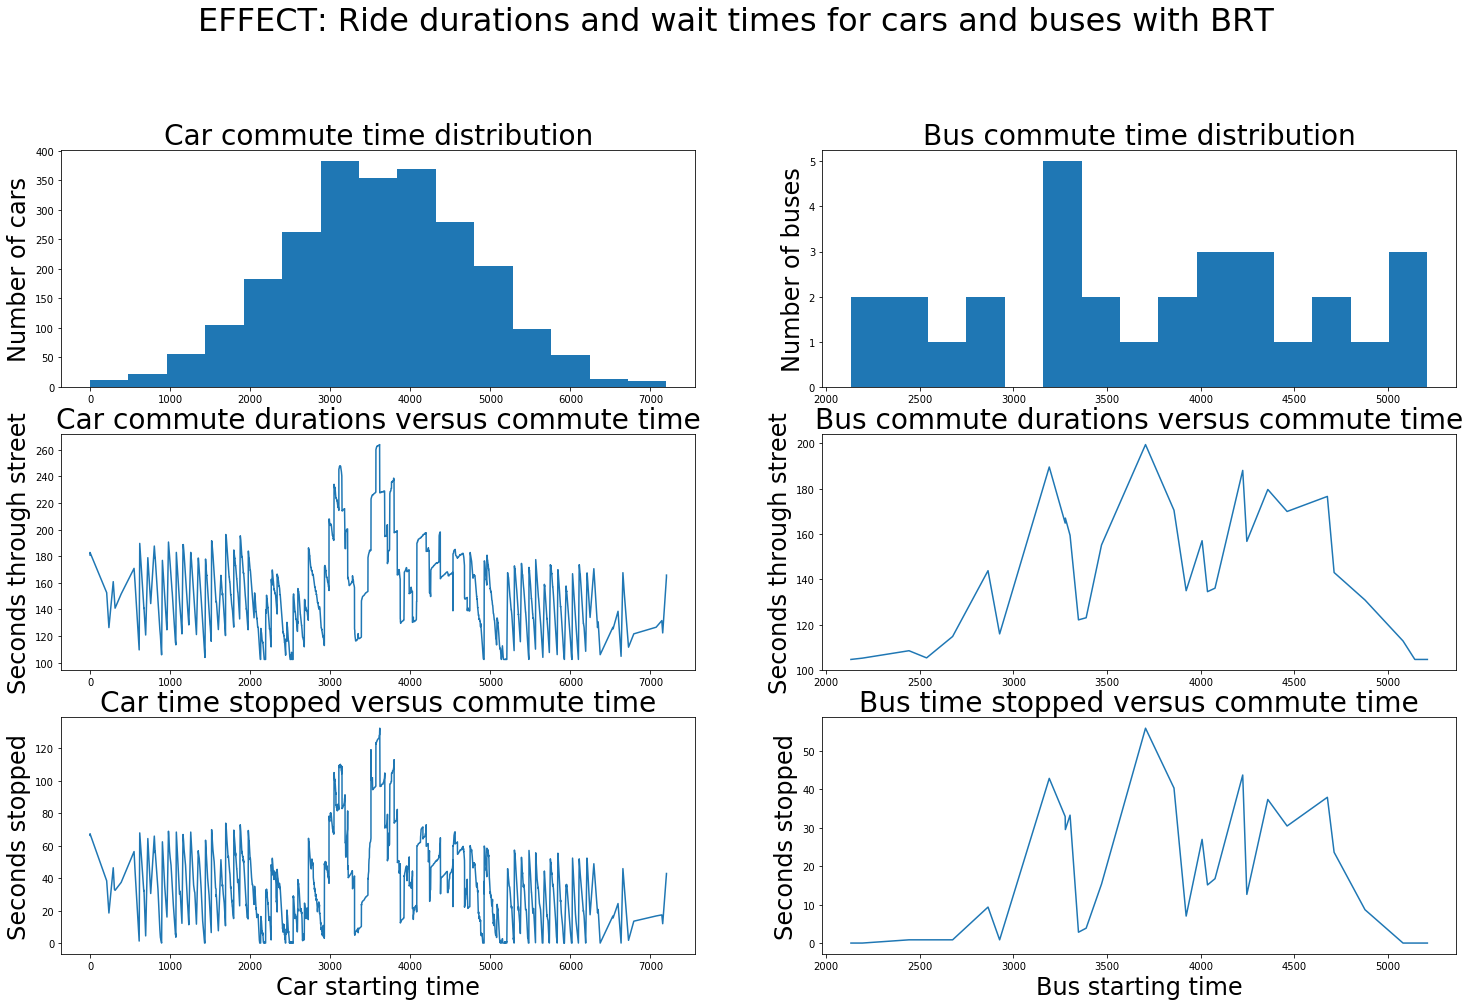

In [24]:
plt.subplots(figsize = [25,20])
plt.suptitle("EFFECT: Ride durations and wait times for cars and buses with BRT", fontsize=32)


plt.subplot(4,2,1)
plt.hist(car_start_times, bins=15)
# plt.xlabel("Car Starting time", fontsize=24)
plt.ylabel("Number of cars", fontsize=24)
plt.title("Car commute time distribution", fontsize = 28)

plt.subplot(4,2,2)
plt.hist(bus_start_times, bins=15)
# plt.xlabel("Bus Starting time", fontsize=24)
plt.ylabel("Number of buses", fontsize=24)
plt.title("Bus commute time distribution", fontsize = 28)

plt.subplot(4,2,3)
plt.plot(car_start_times, BRT_CAR_DURATIONS)
# plt.xlabel("Car starting time",fontsize=24)
plt.ylabel("Seconds through street",fontsize=24)
plt.title("Car commute durations versus commute time", fontsize = 28)

plt.subplot(4,2,4)
plt.plot(bus_start_times, BRT_BUS_DURATIONS)
# plt.xlabel("Bus starting time",fontsize=24)
plt.ylabel("Seconds through street",fontsize=24)
plt.title("Bus commute durations versus commute time", fontsize = 28)

plt.subplot(4,2,5)
plt.plot(car_start_times, BRT_CAR_STOP_DURATIONS)
plt.xlabel("Car starting time",fontsize=24)
plt.ylabel("Seconds stopped",fontsize=24)
plt.title("Car time stopped versus commute time", fontsize = 28)

plt.subplot(4,2,6)
plt.plot(bus_start_times, BRT_BUS_STOP_DURATIONS)
plt.xlabel("Bus starting time",fontsize=24)
plt.ylabel("Seconds stopped",fontsize=24)
plt.title("Bus time stopped versus commute time", fontsize = 28)


# plt.subplot(4,2,7)
# plt.plot(car_start_times, CAR_QUEUE_DURATIONS)
# plt.xlabel("Starting time",fontsize=24)
# plt.ylabel("Seconds queued",fontsize=24)

# plt.subplot(4,2,8)
# plt.plot(bus_start_times, BUS_QUEUE_DURATIONS)
# plt.xlabel("Starting time",fontsize=24)
# plt.ylabel("Seconds queued",fontsize=24)


plt.show()

In [14]:
# Reset variables for new simulation

for vehicle in new_vehicles:
    vehicle.reset()
    
# globals to store exited vehicle information
CAR_DURATIONS = []
CAR_STOP_DURATIONS = []
CAR_QUEUE_DURATIONS = []

BUS_DURATIONS = []
BUS_STOP_DURATIONS = []
BUS_QUEUE_DURATIONS = []

In [15]:
BRT = False
road = Road(LIGHT_LOCATIONS, LIGHT_DUTIES, LIGHT_CYCLES, LIGHT_PHASES, NUM_LANES)
road.simulate(new_vehicles, TIMESTEP)

720 seconds passed
1440 seconds passed
2160 seconds passed
2880 seconds passed
3600 seconds passed
4320 seconds passed
5040 seconds passed
5760 seconds passed
6480 seconds passed
7200 seconds passed


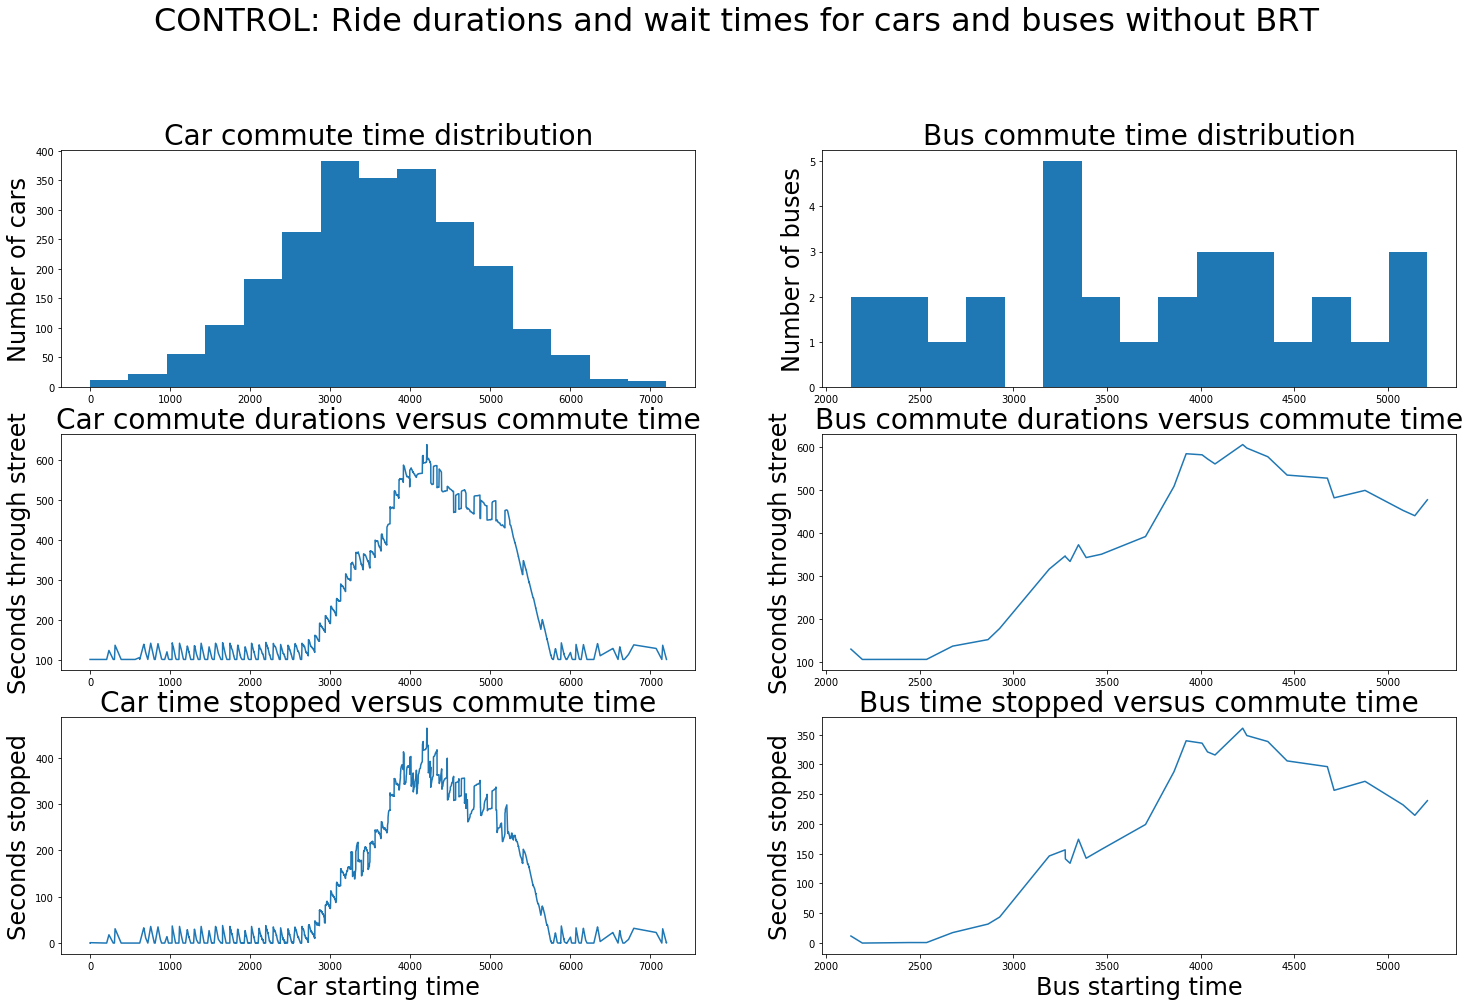

In [23]:
plt.subplots(figsize = [25,20])
plt.suptitle("CONTROL: Ride durations and wait times for cars and buses without BRT", fontsize=32)


plt.subplot(4,2,1)
plt.hist(car_start_times, bins=15)
# plt.xlabel("Car Starting time", fontsize=24)
plt.ylabel("Number of cars", fontsize=24)
plt.title("Car commute time distribution", fontsize = 28)

plt.subplot(4,2,2)
plt.hist(bus_start_times, bins=15)
# plt.xlabel("Bus Starting time", fontsize=24)
plt.ylabel("Number of buses", fontsize=24)
plt.title("Bus commute time distribution", fontsize = 28)

plt.subplot(4,2,3)
plt.plot(car_start_times, CAR_DURATIONS)
# plt.xlabel("Car starting time",fontsize=24)
plt.ylabel("Seconds through street",fontsize=24)
plt.title("Car commute durations versus commute time", fontsize = 28)

plt.subplot(4,2,4)
plt.plot(bus_start_times, BUS_DURATIONS)
# plt.xlabel("Bus starting time",fontsize=24)
plt.ylabel("Seconds through street",fontsize=24)
plt.title("Bus commute durations versus commute time", fontsize = 28)

plt.subplot(4,2,5)
plt.plot(car_start_times, CAR_STOP_DURATIONS)
plt.xlabel("Car starting time",fontsize=24)
plt.ylabel("Seconds stopped",fontsize=24)
plt.title("Car time stopped versus commute time", fontsize = 28)

plt.subplot(4,2,6)
plt.plot(bus_start_times, BUS_STOP_DURATIONS)
plt.xlabel("Bus starting time",fontsize=24)
plt.ylabel("Seconds stopped",fontsize=24)
plt.title("Bus time stopped versus commute time", fontsize = 28)


# plt.subplot(4,2,7)
# plt.plot(car_start_times, CAR_QUEUE_DURATIONS)
# plt.xlabel("Starting time",fontsize=24)
# plt.ylabel("Seconds queued",fontsize=24)

# plt.subplot(4,2,8)
# plt.plot(bus_start_times, BUS_QUEUE_DURATIONS)
# plt.xlabel("Starting time",fontsize=24)
# plt.ylabel("Seconds queued",fontsize=24)


plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f681e4f9fd0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f681f121da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f681f121518>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f681f121cf8>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f681e4f91d0>,
  <matplotlib.lines.Line2D at 0x7f681f126ef0>]}

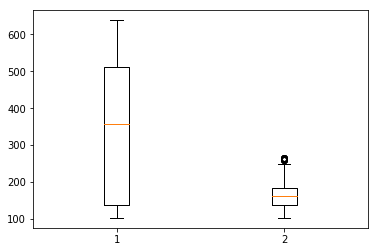

In [17]:
plt.boxplot([CAR_DURATIONS, BRT_CAR_DURATIONS])

{'boxes': [<matplotlib.lines.Line2D at 0x7f681e4db9e8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f681e4db390>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f681e4ed6d8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f681e4ed828>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f681e4dbf98>,
  <matplotlib.lines.Line2D at 0x7f681e4f2438>]}

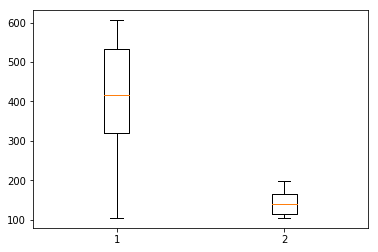

In [18]:
plt.boxplot([BUS_DURATIONS, BRT_BUS_DURATIONS])

{'boxes': [<matplotlib.lines.Line2D at 0x7f681e4d27f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f681f057240>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f681f057eb8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f681f057a90>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f681e4d2940>,
  <matplotlib.lines.Line2D at 0x7f681f05ab70>]}

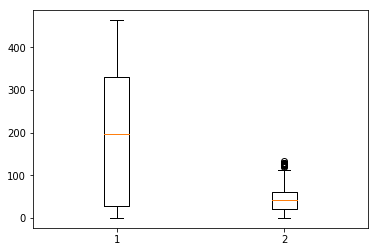

In [19]:
plt.boxplot([CAR_STOP_DURATIONS, BRT_CAR_STOP_DURATIONS])

{'boxes': [<matplotlib.lines.Line2D at 0x7f681f005550>,
 'caps': [<matplotlib.lines.Line2D at 0x7f681f005f60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f681f137c18>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f681f1377f0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f681f0056a0>,
  <matplotlib.lines.Line2D at 0x7f681f12d8d0>]}

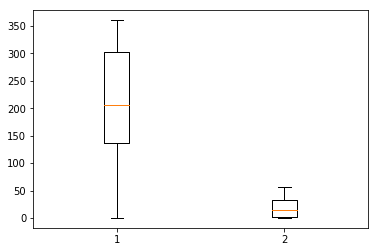

In [20]:
plt.boxplot([BUS_STOP_DURATIONS, BRT_BUS_STOP_DURATIONS])